# Self-Driving Car Engineer Nanodegree

## Deep Learning


This is an adaptation to the traffic sign classifier network the train on the cifar10 dataset.

---
## Step 0: Load The Data

Download and extract the file:

In [1]:
import tensorflow as tf
import pandas as pd

In [4]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# y_train.shape is 2d, (50000, 1). While Keras is smart enough to handle this
# it's a good idea to flatten the array.
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)



Untaring file...


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify = y_train)

### Basic Summary of the Data Set 

In [6]:
import numpy as np

In [7]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# SOLUTION: Number of training examples
n_train = y_train.shape[0]

# SOLUTION: Number of validation examples
n_validation = y_valid.shape[0]

# SOLUTION: Number of testing examples.
n_test = y_test.shape[0]

# SOLUTION: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# SOLUTION: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35000
Number of validation examples = 15000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


### Exploratory visualization of the dataset

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Lets take a look at the class distributions per set.

In [9]:
import pandas as pd
def class_histogram(labels, title_postfix = ""):
    pd.DataFrame(labels).hist(bins = n_classes, grid = False)
    plt.title("Distribution of Labels" + title_postfix)
    plt.xlabel("Class Number")

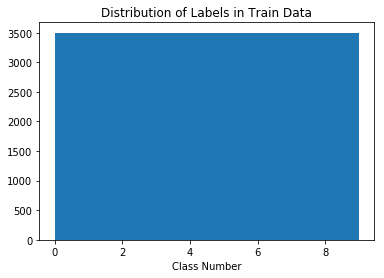

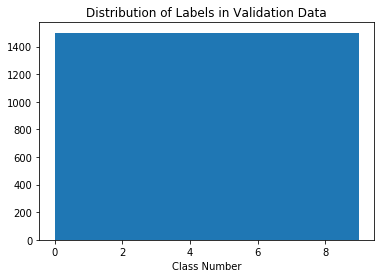

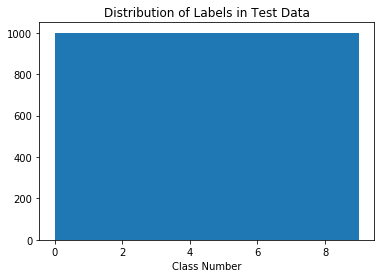

In [10]:
class_histogram(y_train, " in Train Data")
class_histogram(y_valid, " in Validation Data")
class_histogram(y_test, " in Test Data")

Class distribution is pretty much the same on each set, though there are more prominent classes than others. To improve results further, one could rebalance the class distribution with augmented images.

----

## Step 2: Model Architecture



### Pre-processing

For preprocessing the images are normalized, so every image uses the full brightness spectrum from value 0 to value 255. This improves images that are very dark, but also adds shifts in colour. One could use better techniques to normalize the brightness, as converting in the HSL colorspace and normalize brighntess there. 

Normalizing the images improved the accuracy of the net.

For augmentation a random brightness is added and then the images get normalized. Brightness is added before normalizing, to emulate different conditions when the picture was taken. Also random translations, rotations, sheering and scaling was added. These augmentation techniques are used quite often with image recognition tasks and should improve overfitting. 

At last the image values where converted to a -1.0 to 1.0 range for deep learning.

In [11]:
def to_float_image(images):
    """
    Converts images in the range 0 - 255 to the range 0.0 - 1.0.
    This can still be plotted with matplotlib.
    """
    return images.astype(np.float32) / 255.0

This type of normalization changes the colors of the images a lot when the images are dark, as every colorchannel gets multiplied by a constant factor. To improve on this, one could convert the image to the HSL colorspace, adjust the lightnes and convert back to rgb.

In [12]:
def normalize(images):
    """
    The pixel values of a normalized image range from 0 to 255. 
    So if an images darkest pixel is 10 and brightest pixel is 200,
    after normalzing they are 0 and 255. All other pixel values are 
    scaled accordingly.
    """
    result = np.empty(images.shape)
    for i in range(len(images)):
        image = images[i].astype(np.float32)
        image -= image.min()
        image *= (255.0/image.max())
        result[i] = image
    return result.astype(np.ubyte)

In [13]:
def float_image_to_deep_learning_input(images):
    """
    Input should have values in the range 0.0 - 1.0.
    Returns images in the range -1.0 - 1.0.
    This can not be plotted with matplotlib.
    """
    return (images - 0.5) * 2

In [14]:
from skimage import transform as itrf
def augment_image(image):
    """
    Adds random brightnes, shearing, rotation, translation and scaling to the image.
    """
    random_brightnes = np.clip(np.random.normal(loc = 1.0, scale = 0.5), 0.1, 3.0)
    image = np.clip((image * random_brightnes),0, 255).astype(np.ubyte)
    image = normalize(image)
    
    random_shear = np.random.normal(loc = 0.0, scale = 0.1)
    random_scale = (np.random.normal(loc = 1.0, scale = 0.1), np.random.normal(loc = 1.0, scale = 0.1))
    random_rotation = np.random.normal(loc = 0.0, scale = 0.1)
    random_translation = (np.random.normal(loc = 0.0, scale = 0.1), np.random.normal(loc = 0.0, scale = 0.1))
    afine_tf = itrf.AffineTransform(shear = random_shear, scale = random_scale, rotation = random_rotation)
    # print("Shear: " +  str(random_shear) + " Scale: " +  str(random_scale) + " Rot: " + str(random_rotation) + " Bright: " + str(random_brightnes))
    return itrf.warp(image, inverse_map=afine_tf)

Example of one image augmentation. (Execute multiple times to see the randomness)

Here I will show the results of different augmentation steps:

Original Image:

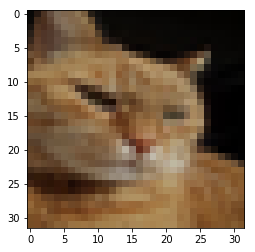

In [15]:
plt.imshow(X_train[100])

Adding random brightness:

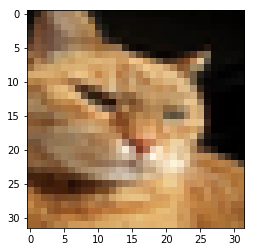

In [16]:
random_brightnes = np.clip(np.random.normal(loc = 1.0, scale = 0.5), 0.1, 3.0)
image = np.clip((X_train[100] * random_brightnes),0, 255).astype(np.ubyte)
plt.imshow(image)

Normalizing:

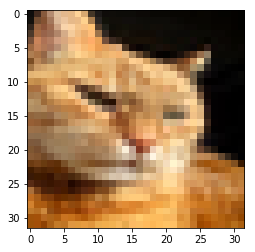

In [17]:
image = normalize(image)
plt.imshow(image)

Random rotation, scale, sheer and translation. This is done at once by multipling the image with a warp matrix.

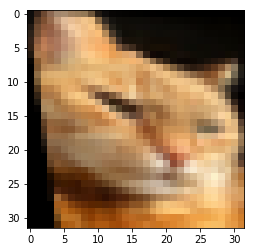

In [18]:
random_shear = np.random.normal(loc = 0.0, scale = 0.1)
random_scale = (np.random.normal(loc = 1.0, scale = 0.1), np.random.normal(loc = 1.0, scale = 0.1))
random_rotation = np.random.normal(loc = 0.0, scale = 0.1)
random_translation = (np.random.normal(loc = 0.0, scale = 0.1), np.random.normal(loc = 0.0, scale = 0.1))
afine_tf = itrf.AffineTransform(shear = random_shear, scale = random_scale, rotation = random_rotation)
image = itrf.warp(image, inverse_map=afine_tf)
plt.imshow(image)

In [19]:
def image_augmentation_pipeline(images):
    result = np.zeros(images.shape)
    for i in range(len(images)):
        result[i] = augment_image(images[i])
    
    return result

In [20]:
def prepare_images_for_deep_learning(images):
    images = normalize(images)
    images = to_float_image(images)
    images = float_image_to_deep_learning_input(images)
    return images

### Augmentation 

Here the augmentation of images get calculated. I tried to generate the augmented images during the training loop to add randomness and save memory, but that increased the training time significantly, which i did not prefer. I wanted to observe the improvements of the net while training so I could stop training early on bad results. Therefore I needed a fast training pipeline. So the images are generated before training.

In [21]:
%%time
AUGMENTATION_RUNS = 5
X_train_augmented =  np.zeros((AUGMENTATION_RUNS,) + X_train.shape)
for i in range(AUGMENTATION_RUNS):
    X_train_augmented[i] = image_augmentation_pipeline(X_train)
    

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


CPU times: user 3min 23s, sys: 1.17 s, total: 3min 24s
Wall time: 3min 24s


### Image Preparation for Deep Learning

In [22]:
X_train_prepared = prepare_images_for_deep_learning(X_train)
X_train_augmented_prepared = prepare_images_for_deep_learning(X_train_augmented)
X_test_prepared = prepare_images_for_deep_learning(X_test)
X_valid_prepared = prepare_images_for_deep_learning(X_valid)

### Model Architecture

Below is a table of the architecture. It is the same as the LeNet-5 architecture with more depth in the filters and therefore more fully connected nodes.

| Layer           | Description                                 |
|-----------------|---------------------------------------------|
| Input           | 32x32x3 Image Data                          |
| Convolution 5x5 | Valid Padding, 1x1 Strides, 28x28x16 Output |
| Relu            |                                             |
| Max Pool        | 2x2 Strides, 14x14x16 Output                |
| Convolution 5x5 | Valid Padding, 1x1 Strides, 10x10x32 Output |
| Relu            |                                             |
| Max Pool        | 2x2 Strides, 5x5x32 Output                  |
| Flatten         | 800 Output                                  |
| Fully Connected | 200 Output                                  |
| Relu            |                                             |
| Fully Connected | 100 Output                                  |
| Relu            |                                             |
| Dropout         | 50% Keep Probability                        |
| Fully Connected | Output 43                                   |

### Architecture and training approach

I used the same architecture as the LeNet-5 net, as it was build for image classification tasks. Also most of the code got implemented earlier in the nanodegree so it seemed obvious to reuse the code.

To improve the accuracy of the net, I changed the depth of the filters and therefore I had to increase the number of fully connected neurons accordingly. At first I started with quite deep filters, and a lot of neurons. Then I decreased the filters step by step to prevent overfitting  until I got good results. 

I tried to create an overfitting model first, so I know that the model is able to learn the concepts. Then I tried to decrease overfitting by decreasing filter depths, adding a dropout layer with a 50% keep probability and image augmentation.

I used the adam optimizer with its default learning rate of 0.001. I tried to lower the training rate, but that seemed to increase training time without accuracy improvements. The adam optimizer should addapt the training rate anyways.

I also tried to increase the batch size until I run in memory issues, but that seemed to lower the accuracy somehow. So I kept the batch size at 512. The model ran for 30 Epochs, but it didn't improve after 20.

As a final result I got a validation accuracy of 0.943 and test accuracy of 0.95. 

In the loss chart below the training segment you can see that validations loss starts to rise again after about 10 Epochs of training. That shows that the net is still overfitting, but I'm happy with the results it produces anyways.

In [28]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(16), name="conv1_b")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1, name="conv1_relu")

    # SOLUTION: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name="conv1_maxpool")

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma), name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(32), name="conv2_b")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2, name="conv2_relu")

    # SOLUTION: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name="conv2_maxpool")

    # SOLUTION: Flatten. Input = 5x5x36. Output = 800.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 800. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 200. Output = 100.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    drop = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 100. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(drop, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Variables

In [29]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name= "x")
y = tf.placeholder(tf.int32, (None), name= "y")
one_hot_y = tf.one_hot(y, 10, name= "one_hot_encoder")
keep_prob = tf.placeholder(tf.float32)

Training Pipeline

In [30]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Evaluation

In [31]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))

    return total_accuracy / num_examples, total_loss / num_examples

Training

In [32]:
from sklearn.utils import shuffle

EPOCHS = 30
BATCH_SIZE = 512
dropout = 0.5

Training...

EPOCH 1 ...
Train Accuracy = 0.436
Validation Accuracy = 0.430
Validation Loss = 1.60262563286

EPOCH 2 ...
Train Accuracy = 0.499
Validation Accuracy = 0.486
Validation Loss = 1.42819206518

EPOCH 3 ...
Train Accuracy = 0.566
Validation Accuracy = 0.550
Validation Loss = 1.25443380566

EPOCH 4 ...
Train Accuracy = 0.611
Validation Accuracy = 0.580
Validation Loss = 1.18290928701

EPOCH 5 ...
Train Accuracy = 0.633
Validation Accuracy = 0.595
Validation Loss = 1.14028651492

EPOCH 6 ...
Train Accuracy = 0.685
Validation Accuracy = 0.632
Validation Loss = 1.0460223285

EPOCH 7 ...
Train Accuracy = 0.692
Validation Accuracy = 0.629
Validation Loss = 1.04890724347

EPOCH 8 ...
Train Accuracy = 0.733
Validation Accuracy = 0.659
Validation Loss = 0.985899239731

EPOCH 9 ...
Train Accuracy = 0.743
Validation Accuracy = 0.659
Validation Loss = 0.996404726919

EPOCH 10 ...
Train Accuracy = 0.743
Validation Accuracy = 0.650
Validation Loss = 1.02511428235

EPOCH 11 ...
Train Accura

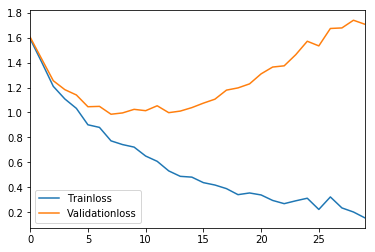

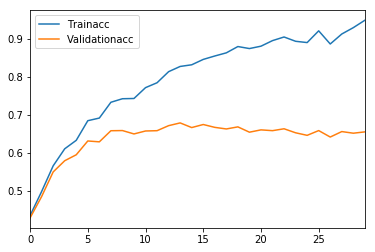

In [33]:
%%time



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_prepared)
    
    train_losses = []
    validation_losses = []
    
    train_accs = []
    validation_accs = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # Shuffle normal images.
        X_train_shuffled, y_train_shuffled = shuffle(X_train_prepared, y_train)
        
        # Shuffle augmentated images.
        for k in range(AUGMENTATION_RUNS):
            X_train_augmented_shuffled = np.zeros(X_train_augmented_prepared.shape)
            y_train_augmented_shuffled = np.zeros((AUGMENTATION_RUNS,) + y_train.shape)
            X_train_augmented_shuffled[k], y_train_augmented_shuffled[k] = shuffle(X_train_augmented_prepared[k], y_train)

        # Do Batch runs.
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            
            # do a normal run.
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
            # do runs with augmentated images.
            for augmentation_run in range(AUGMENTATION_RUNS):
                augmented_batch_x, augmented_batch_y = X_train_augmented_shuffled[augmentation_run][offset:end], y_train_augmented_shuffled[augmentation_run][offset:end]
                sess.run(training_operation, feed_dict={x: augmented_batch_x, y: augmented_batch_y, keep_prob: dropout})
       
        # Calculate and print losses and accuracies.
        train_accuracy, train_loss = evaluate(X_train_prepared, y_train)
        validation_accuracy, validation_loss = evaluate(X_valid_prepared, y_valid)
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        
        train_accs.append(train_accuracy)
        validation_accs.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {0:.3f}".format(train_accuracy))
        print("Validation Accuracy = {0:.3f}".format(validation_accuracy))
        print("Validation Loss = " + str(validation_loss))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
    pd.DataFrame({"Trainloss": train_losses, "Validationloss": validation_losses}).plot()
    pd.DataFrame({"Trainacc": train_accs, "Validationacc": validation_accs}).plot()

Final test

In [34]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss = evaluate(X_test_prepared, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.661


### Missclassified Images

In [35]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    prediction = tf.argmax(logits,1)
    pred = sess.run(prediction, feed_dict = {x: X_test_prepared,  keep_prob: 1.0})
 

In [36]:
from sklearn.metrics import confusion_matrix

def plot_nth_most_confused(n, true_values, predicted_values):
    conf = confusion_matrix(true_values, predicted_values)
    np.fill_diagonal(conf, 0)

    flat = conf.flatten()
    flat.sort()

    real, pred = np.where(conf == flat[-n])
    real_class = np.where(y_test == real)[0][0]
    pred_class = np.where(y_test == pred)[0][0]

    plt.subplot(1, 2, 1)
    plt.imshow((X_test[real_class]))
    plt.subplot(1, 2, 2)
    plt.imshow((X_test[pred_class]))




This are examples for the most confused classes from most confusions to less confusions. The signs are very similiar indeed. 

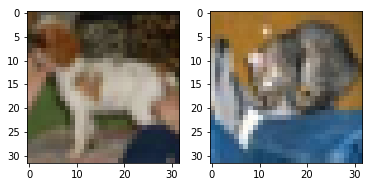

In [37]:
plot_nth_most_confused(1, y_test, pred)

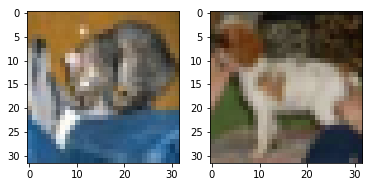

In [38]:
plot_nth_most_confused(2, y_test, pred)

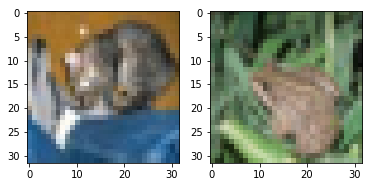

In [39]:
plot_nth_most_confused(3, y_test, pred)

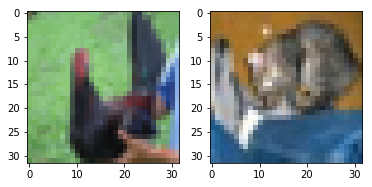

In [40]:
plot_nth_most_confused(4, y_test, pred)